In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pytorch_lightning as pl
from glob import glob
from models import pretrained
from data.camelyon import CamelyonModule

In [2]:
dm = CamelyonModule(batch_size=1024)
# trainer = pl.Trainer(gpus=[1, ])
models = pretrained.all_camelyon_model(wilds=False, device=None)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.47it/s]


In [ ]:
accs = [trainer.validate(model, dm.test_dataloader())[0]['val_acc'] for model in models]
pred_accs = [trainer.validate(model, dm.predict_dataloader())[0]['val_acc'] for model in models]
val_accs = [trainer.validate(model, dm.val_dataloader())[0]['val_acc'] for model in models]

In [3]:
import matplotlib.pyplot as plt

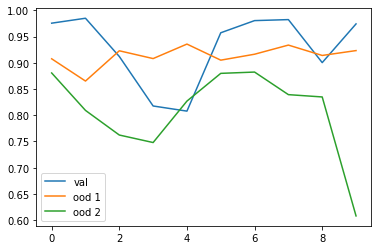

In [31]:
plt.plot(pred_accs, label='val')
plt.plot(val_accs, label='ood 1')
plt.plot(accs, label='ood 2')
plt.legend()

In [7]:
torch.tensor(accs).mean(), torch.tensor(pred_accs).mean()

(tensor(0.8072), tensor(0.9293))

In [5]:
torch.tensor(val_accs).mean()

tensor(0.9132)

In [9]:
dm.test_dataloader().dataset.__len__()

85054

In [4]:
from wilds.datasets.civilcomments_dataset import CivilCommentsDataset
from wilds.datasets.camelyon17_dataset import Camelyon17Dataset
from wilds.common.data_loaders import get_train_loader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import random
from scipy.stats import ks_2samp

In [5]:
d = Camelyon17Dataset(root_dir='/voyager/datasets')

In [6]:
d[0]

(<PIL.Image.Image image mode=RGB size=96x96 at 0x7F149715BA90>,
 tensor(1),
 tensor([0, 0, 1, 1]))

In [7]:
tr, va, te, idval = [d.get_subset(i) for i in ('train', 'val', 'test', 'id_val')]
ims = []
for dd in (tr, va, te, idval):
    ims.append([])
    for i in range(100, 115):
        ims[-1].append(np.array(dd[i][0]))
    ims[-1] = np.concatenate(ims[-1])

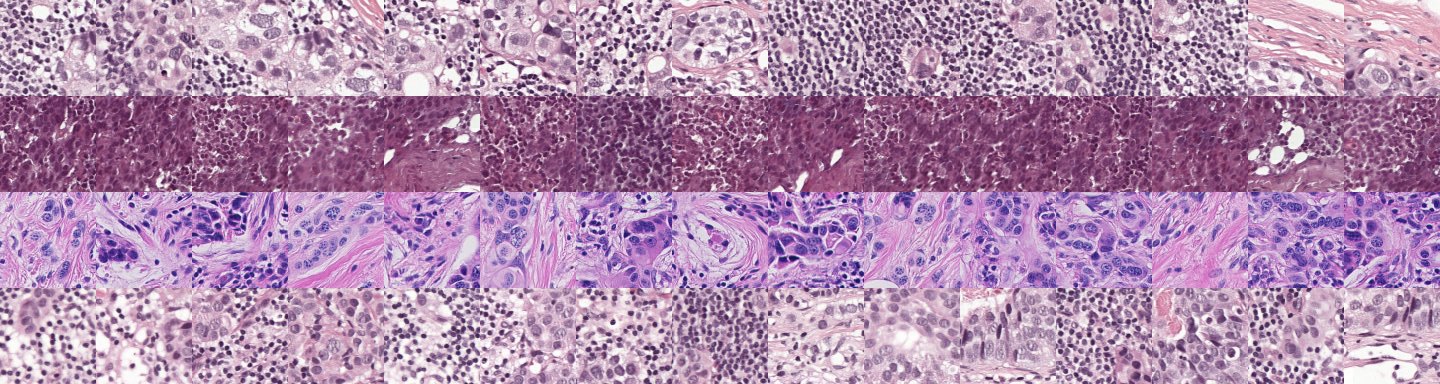

In [8]:
Image.fromarray(np.concatenate(ims, axis=1).transpose(1, 0, 2))

In [19]:
te[30]

(<PIL.Image.Image image mode=RGB size=96x96 at 0x7F14962DC6D0>,
 tensor(1),
 tensor([ 2, 21,  1,  0]))

In [6]:
from shift_detection.ensemblemethods import EnsembleMethods

In [7]:
dm = CamelyonModule(test_samples='all', batch_size=1024)

models, names = pretrained.all_camelyon_model(return_names=True, device='cuda:1', wilds=False)
em = EnsembleMethods(models=models, model_names=names, datamodule=dm, df_path='tables/camelyon/bbsd.json',
                     logit_path='../logits/camelyon', load_logits=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


In [26]:
import numpy as np

In [8]:
em.bbsd_sweep(test_samples=[10, 20, 50], test_seeds=range(100), shifts=(True, False))

10it [00:00, 76.15it/s]


OSError: Cannot save file into a non-existent directory: 'tables/camelyon'

In [38]:
print(list(em.df.query('algorithm=="bbsd"').groupby(['test_samples', 'shift']).significant.sem() * 100))

[0.3845749574502971, 1.2048616898597495, 0.28185003005044973, 1.5445859463771332, 0.39698563903193956, 1.3211720158614835]


In [39]:
print(list(em.df.query('algorithm=="bbsd"').groupby(['test_samples', 'shift']).significant.mean() * 100))

[1.5, 17.599999999999998, 0.8, 39.2, 1.6, 77.5]


In [40]:
em.print_results()

test_samples  shift  algorithm
10            False  bbsd         0.01500
                     ensemble     0.01125
              True   bbsd         0.17600
                     ensemble     0.09875
20            False  bbsd         0.00800
                     ensemble     0.01000
              True   bbsd         0.39200
                     ensemble     0.11375
50            False  bbsd         0.01600
                     ensemble     0.02000
              True   bbsd         0.77500
                     ensemble     0.37250
Name: significant, dtype: float64


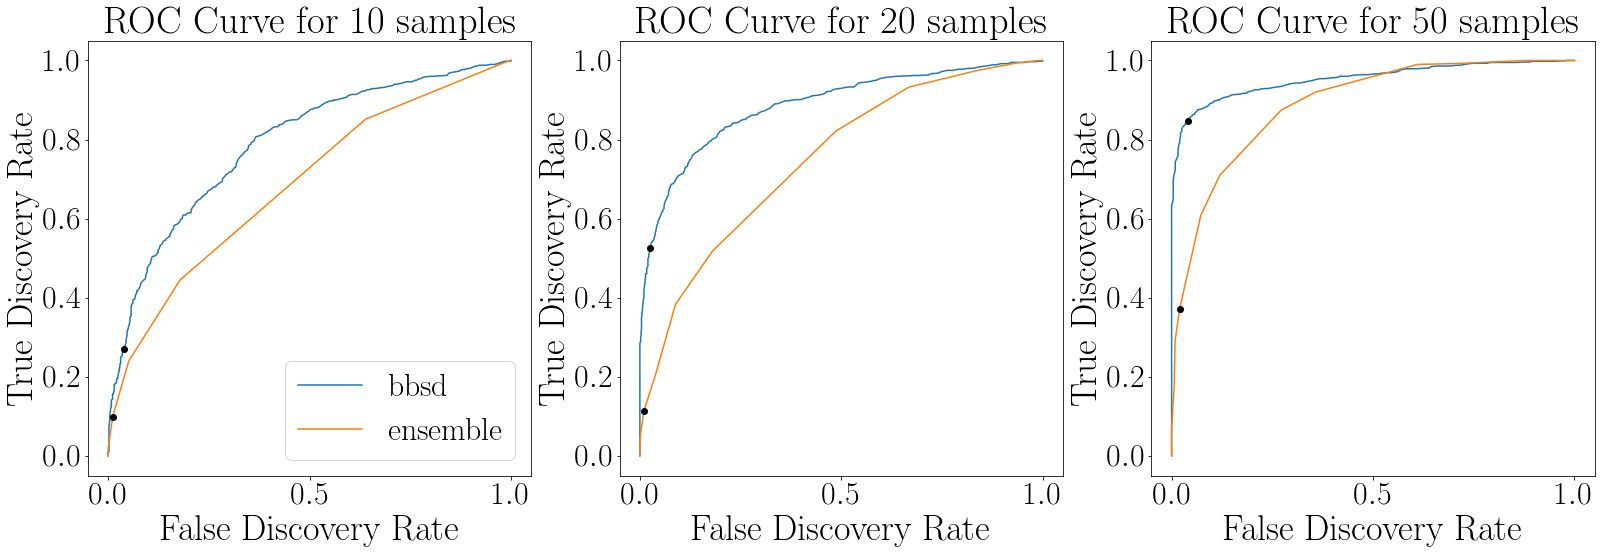

In [63]:
import matplotlib.pyplot as plt
def query_pvals(algo, samples):
    df = em.df.query(f'algorithm=="{algo}" and test_samples=={samples}')
    s = np.array(df.query('shift==True').pvals)
    n = np.array(df.query('shift==False').pvals)
    if algo == 'bbsd':
        s = np.array([min(x) for x in s])
        n = np.array([min(x) for x in n])
    return s, n

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],
    'font.size': 32}
)

from sklearn.metrics import roc_curve
fig, axes = plt.subplots(1,3, figsize=(27, 8), squeeze=False)
for samples, ax in zip([10, 20, 50], axes.ravel()):

    for algo in ['bbsd', 'ensemble']:
        s, n = query_pvals(algo, samples)
        fpr, tpr, thr = roc_curve(y_score=(1 - np.concatenate([s, n])),
                                  y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]))
        ax.plot(fpr, tpr, label=algo if samples == 10 else None)
        ax.plot((n < 0.05).mean(), (s < 0.05).mean(), 'o', color='black')

    ax.set_xlabel('False Discovery Rate', fontdict={'fontsize': 36})
    ax.set_ylabel('True Discovery Rate', fontdict={'fontsize': 36})
    if samples==10:
        ax.legend()
    ax.set_title(f'ROC Curve for {samples} samples')

plt.savefig('roc_curves_camelyon.pdf')

In [2]:
import pandas as pd

df = pd.read_json('../tables/camelyon/bbsd.json')
g = df.groupby(['test_samples', 'shift', 'algorithm']).significant.mean()

In [8]:
df.groupby(['test_samples', 'shift', 'algorithm']).significant.mean()

test_samples  shift  algorithm
10            False  bbsd         0.015
                     ensemble     0.000
              True   bbsd         0.176
                     ensemble     0.090
              val    bbsd         0.166
                     ensemble     0.000
20            False  bbsd         0.008
                     ensemble     0.010
              True   bbsd         0.392
                     ensemble     0.100
              val    bbsd         0.418
                     ensemble     0.000
50            False  bbsd         0.016
                     ensemble     0.030
              True   bbsd         0.775
                     ensemble     0.340
              val    bbsd         0.704
                     ensemble     0.000
100           False  bbsd         0.041
                     ensemble     0.000
              True   bbsd         0.895
                     ensemble     0.590
              val    bbsd         0.883
                     ensemble     0.000
1000     

In [65]:
d = pd.read_csv('checkpoints/camelyon/rej-1/rejectron_results.csv')

In [71]:
d

,Step,train_agree,test_reject,train_acc,test_acc,p_q_score,val_agree,val_acc,test_samples,test_seed,shift
0,0.0,1.000000,0.00,0.979178,1.000000,10.00,1.000,0.910000,10,0,True
1,4.0,0.975065,1.00,0.996882,1.000000,98.00,0.538,0.895911,10,1,True
2,4.0,0.975731,1.00,0.996905,1.000000,98.00,0.835,0.910180,10,2,True
3,9.0,0.976538,0.80,0.996883,1.000000,97.80,0.826,0.912833,10,0,True
4,10.0,0.976111,0.70,0.996735,0.333333,97.70,0.641,0.893916,10,4,True
5,10.0,0.975981,0.70,0.996840,0.666667,97.70,0.862,0.918793,10,5,True
6,8.0,0.977274,0.80,0.996767,1.000000,97.80,0.854,0.914520,10,6,True
7,10.0,0.975598,0.90,0.996898,1.000000,97.90,0.853,0.924971,10,7,True
8,10.0,0.976535,0.80,0.996890,0.500000,97.80,0.834,0.911271,10,8,True
9,10.0,0.976289,0.70,0.996802,1.000000,97.70,0.857,0.919487,10,9,True
